In [1]:
import pandas as pd
import numpy as np

from sklearn import pipeline, ensemble, model_selection, metrics

from skopt import BayesSearchCV

import datamol as dm

from rdkit.Chem.Crippen import MolLogP

np.int = int

## чтение + формирование X

### для попова

In [2]:
df_train = pd.read_csv("logP-14000.csv").dropna()

smi = df_train.SMILES

list_smi_canon = []

for smiles in smi:
    mol = dm.to_mol(smiles)
    canon_smi = dm.to_smiles(mol, canonical=True)
    list_smi_canon.append(canon_smi)

df_train.insert(1, "canon_smi", list_smi_canon, False)  # добавили колонку

df_train.drop_duplicates(
    subset="canon_smi", keep="first", inplace=True
)  # удалили дубликаты, оставляя только первое входящее веществоP

y_train = df_train.Kow

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
smiles_Popova = df_train.SMILES

mols_Popova = [dm.to_mol(smiles) for smiles in smiles_Popova]

fps_Popova = [
    dm.to_fp(mol, fp_type="ecfp-count", nBits=1024 * 4) for mol in mols_Popova
]

X_train = pd.DataFrame(data=np.array(fps_Popova))  # сделаем не только с 0 и 1
X_train

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Martel

In [4]:
df_test = pd.read_csv("/data/datasets/martel.tsv", sep="\t")

y_test = df_test.LogP

smiles_Martel = df_test.Smiles

mols_Martel = [dm.to_mol(smiles) for smiles in smiles_Martel]

fps_Martel = [
    dm.to_fp(mol, fp_type="ecfp-count", nBits=1024 * 4) for mol in mols_Martel
]

X_test = pd.DataFrame(data=np.array(fps_Martel))
X_test

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### из статьи

In [5]:
MAIN_MOLS = pd.read_csv(
    "MOLS.csv"
)  # работает только на ядре 3.12.1, которе не стоит в рекомендованном
smiles = MAIN_MOLS.SMILES
names = list(MAIN_MOLS.NAME)

mols = [dm.to_mol(smiles) for smiles in smiles]
# dm.to_image(mols=mols, legends=names)

In [6]:
fps_16 = [dm.to_fp(mol, fp_type="ecfp-count", nBits=1024 * 4) for mol in mols]

X_test_fps_16 = pd.DataFrame(data=np.array(fps_16))
X_test_fps_16

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Params tuning

In [7]:
kf = model_selection.RepeatedKFold(
    n_splits=5,
    n_repeats=1,
    random_state=42,
)

In [24]:
wide_grid = {
    "max_features": np.linspace(0.1, 1, 10, dtype="float"),
    "n_estimators": np.linspace(10, 3000, 5, dtype="int"),
    "max_depth": np.linspace(10, 500, 10, dtype="int"),
    "max_leaf_nodes": np.linspace(1, 14000, 14, dtype="int"),
    "max_samples": np.linspace(0.1, 1, 10, dtype="float"),
}

In [25]:
wide_rf = ensemble.RandomForestRegressor(
    n_jobs=-1,
    random_state=42,
    min_samples_leaf=1,
    min_samples_split=2,
)

In [27]:
opt = BayesSearchCV(
    wide_rf, wide_grid, cv=5, n_jobs=1, scoring="r2", verbose=3, n_iter=12
)

In [28]:
opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=282, max_features=0.30000000000000004, max_leaf_nodes=8615, max_samples=0.9, n_estimators=2252;, score=0.763 total time= 4.2min
[CV 2/5] END max_depth=282, max_features=0.30000000000000004, max_leaf_nodes=8615, max_samples=0.9, n_estimators=2252;, score=0.788 total time= 4.2min
[CV 3/5] END max_depth=282, max_features=0.30000000000000004, max_leaf_nodes=8615, max_samples=0.9, n_estimators=2252;, score=0.830 total time= 4.1min
[CV 4/5] END max_depth=282, max_features=0.30000000000000004, max_leaf_nodes=8615, max_samples=0.9, n_estimators=2252;, score=0.785 total time= 4.3min
[CV 5/5] END max_depth=282, max_features=0.30000000000000004, max_leaf_nodes=8615, max_samples=0.9, n_estimators=2252;, score=0.728 total time= 4.2min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=336, max_features=0.30000000000000004, max_leaf_nodes=9692, max_samples=0.5, n_estimators=1505;, score=0

BayesSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
              n_iter=12, scoring='r2',
              search_spaces={'max_depth': array([ 10,  64, 118, 173, 227, 282, 336, 391, 445, 500]),
                             'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                             'max_leaf_nodes': array([    1,  1077,  2154,  3231,  4308,  5385,  6462,  7538,  8615,
        9692, 10769, 11846, 12923, 14000]),
                             'max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                             'n_estimators': array([  10,  757, 1505, 2252, 3000])},
              verbose=3)

In [30]:
opt.best_score_, opt.best_params_

(0.7788412941816321,
 OrderedDict([('max_depth', 282),
              ('max_features', 0.30000000000000004),
              ('max_leaf_nodes', 8615),
              ('max_samples', 0.9),
              ('n_estimators', 2252)]))

In [35]:
narrow_grid = {
    "max_features": np.linspace(0.1, 0.5, 5, dtype="float"),
    "n_estimators": np.linspace(2000, 3500, 5, dtype="int"),
    "max_depth": np.linspace(250, 500, 11, dtype="int"),
    "max_leaf_nodes": np.linspace(8000, 14000, 13, dtype="int"),
}

In [36]:
narrow_rf = ensemble.RandomForestRegressor(
    n_jobs=-1,
    random_state=42,
    min_samples_leaf=1,
    min_samples_split=2,
)

In [37]:
opt_narrow = BayesSearchCV(
    narrow_rf, narrow_grid, cv=5, n_jobs=1, scoring="r2", verbose=3, n_iter=12
)

In [38]:
opt_narrow.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=350, max_features=0.4, max_leaf_nodes=8500, n_estimators=3125;, score=0.767 total time= 7.9min
[CV 2/5] END max_depth=350, max_features=0.4, max_leaf_nodes=8500, n_estimators=3125;, score=0.791 total time= 7.9min
[CV 3/5] END max_depth=350, max_features=0.4, max_leaf_nodes=8500, n_estimators=3125;, score=0.832 total time= 7.8min
[CV 4/5] END max_depth=350, max_features=0.4, max_leaf_nodes=8500, n_estimators=3125;, score=0.787 total time= 8.1min
[CV 5/5] END max_depth=350, max_features=0.4, max_leaf_nodes=8500, n_estimators=3125;, score=0.724 total time= 8.1min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=450, max_features=0.30000000000000004, max_leaf_nodes=13500, n_estimators=2375;, score=0.766 total time= 4.8min
[CV 2/5] END max_depth=450, max_features=0.30000000000000004, max_leaf_nodes=13500, n_estimators=2375;, score=0.790 total time= 4.7min
[CV 3/5] END max_depth

BayesSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
              n_iter=12, scoring='r2',
              search_spaces={'max_depth': array([250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]),
                             'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                             'max_leaf_nodes': array([ 8000,  8500,  9000,  9500, 10000, 10500, 11000, 11500, 12000,
       12500, 13000, 13500, 14000]),
                             'n_estimators': array([2000, 2375, 2750, 3125, 3500])},
              verbose=3)

In [39]:
opt_narrow.best_score_, opt_narrow.best_params_

(0.7812119598221006,
 OrderedDict([('max_depth', 450),
              ('max_features', 0.30000000000000004),
              ('max_leaf_nodes', 13500),
              ('n_estimators', 2375)]))

In [44]:
narrow_grid_2 = {
    "n_estimators": np.linspace(1500, 4000, 7, dtype="int"),
    "max_depth": np.linspace(350, 650, 7, dtype="int"),
}

In [45]:
narrow_rf_2 = ensemble.RandomForestRegressor(
    n_jobs=-1,
    random_state=42,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=0.3,
)

In [47]:
opt_narrow_2 = BayesSearchCV(
    narrow_rf_2, narrow_grid_2, cv=5, n_jobs=1, scoring="r2", verbose=3, n_iter=10
)

In [48]:
opt_narrow_2.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..max_depth=400, n_estimators=3166;, score=0.766 total time= 4.3min
[CV 2/5] END ..max_depth=400, n_estimators=3166;, score=0.790 total time= 4.3min
[CV 3/5] END ..max_depth=400, n_estimators=3166;, score=0.832 total time= 4.2min
[CV 4/5] END ..max_depth=400, n_estimators=3166;, score=0.787 total time= 4.3min
[CV 5/5] END ..max_depth=400, n_estimators=3166;, score=0.729 total time= 4.3min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..max_depth=650, n_estimators=1916;, score=0.766 total time= 2.6min
[CV 2/5] END ..max_depth=650, n_estimators=1916;, score=0.790 total time= 2.6min
[CV 3/5] END ..max_depth=650, n_estimators=1916;, score=0.832 total time= 2.5min
[CV 4/5] END ..max_depth=650, n_estimators=1916;, score=0.787 total time= 2.6min
[CV 5/5] END ..max_depth=650, n_estimators=1916;, score=0.730 total time= 2.6min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END 

BayesSearchCV(cv=5,
              estimator=RandomForestRegressor(max_features=0.3, n_jobs=-1,
                                              random_state=42),
              n_iter=10, scoring='r2',
              search_spaces={'max_depth': array([350, 400, 450, 500, 550, 600, 650]),
                             'n_estimators': array([1500, 1916, 2333, 2750, 3166, 3583, 4000])},
              verbose=3)

In [49]:
opt_narrow_2.best_score_, opt_narrow_2.best_params_

(0.7808704689393199, OrderedDict([('max_depth', 650), ('n_estimators', 1916)]))

In [53]:
narrow_grid_3 = {
    "n_estimators": np.linspace(1000, 3000, 10, dtype="int"),
    "max_depth": np.linspace(400, 900, 11, dtype="int"),
}

In [54]:
narrow_rf_3 = ensemble.RandomForestRegressor(
    n_jobs=-1,
    random_state=42,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=0.3,
)

In [55]:
opt_narrow_3 = BayesSearchCV(
    narrow_rf_3, narrow_grid_3, cv=5, n_jobs=1, scoring="r2", verbose=3, n_iter=10
)

In [56]:
opt_narrow_3.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..max_depth=550, n_estimators=1000;, score=0.766 total time= 1.4min
[CV 2/5] END ..max_depth=550, n_estimators=1000;, score=0.790 total time= 1.4min
[CV 3/5] END ..max_depth=550, n_estimators=1000;, score=0.832 total time= 1.3min
[CV 4/5] END ..max_depth=550, n_estimators=1000;, score=0.787 total time= 1.4min
[CV 5/5] END ..max_depth=550, n_estimators=1000;, score=0.729 total time= 1.4min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..max_depth=700, n_estimators=2333;, score=0.766 total time= 3.2min
[CV 2/5] END ..max_depth=700, n_estimators=2333;, score=0.790 total time= 3.2min
[CV 3/5] END ..max_depth=700, n_estimators=2333;, score=0.832 total time= 3.1min
[CV 4/5] END ..max_depth=700, n_estimators=2333;, score=0.787 total time= 3.2min
[CV 5/5] END ..max_depth=700, n_estimators=2333;, score=0.729 total time= 3.2min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END 

BayesSearchCV(cv=5,
              estimator=RandomForestRegressor(max_features=0.3, n_jobs=-1,
                                              random_state=42),
              n_iter=10, scoring='r2',
              search_spaces={'max_depth': array([400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900]),
                             'n_estimators': array([1000, 1222, 1444, 1666, 1888, 2111, 2333, 2555, 2777, 3000])},
              verbose=3)

In [57]:
opt_narrow_3.best_score_, opt_narrow_3.best_params_

(0.7808600037050405, OrderedDict([('max_depth', 850), ('n_estimators', 1666)]))

In [8]:
rf_last = ensemble.RandomForestRegressor(
    max_features=0.3,
    n_jobs=-1,
    random_state=42,
    min_samples_leaf=1,
    min_samples_split=2,
)

In [9]:
grid_last = {
    "max_depth": np.linspace(300, 600, 4, dtype="int"),
    "n_estimators": np.linspace(2000, 3000, 3, dtype="int"),
}

In [10]:
gs_last = model_selection.GridSearchCV(
    rf_last,
    grid_last,
    verbose=3,
    n_jobs=1,
    cv=kf,
)

In [11]:
gs_last.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ..max_depth=300, n_estimators=2000;, score=0.870 total time= 7.7min
[CV 2/5] END ..max_depth=300, n_estimators=2000;, score=0.854 total time= 6.3min
[CV 3/5] END ..max_depth=300, n_estimators=2000;, score=0.867 total time= 6.2min
[CV 4/5] END ..max_depth=300, n_estimators=2000;, score=0.849 total time= 6.3min
[CV 5/5] END ..max_depth=300, n_estimators=2000;, score=0.861 total time= 6.3min
[CV 1/5] END ..max_depth=300, n_estimators=2500;, score=0.870 total time= 7.9min
[CV 2/5] END ..max_depth=300, n_estimators=2500;, score=0.854 total time= 7.9min
[CV 3/5] END ..max_depth=300, n_estimators=2500;, score=0.867 total time= 7.7min
[CV 4/5] END ..max_depth=300, n_estimators=2500;, score=0.849 total time= 7.8min
[CV 5/5] END ..max_depth=300, n_estimators=2500;, score=0.861 total time= 7.7min
[CV 1/5] END ..max_depth=300, n_estimators=3000;, score=0.870 total time= 9.2min
[CV 2/5] END ..max_depth=300, n_estimators=3000;

GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
             estimator=RandomForestRegressor(max_features=0.3, n_jobs=-1,
                                             random_state=42),
             n_jobs=1,
             param_grid={'max_depth': array([300, 400, 500, 600]),
                         'n_estimators': array([2000, 2500, 3000])},
             verbose=3)

In [13]:
gs_last.best_score_, gs_last.best_params_

(0.8602011394929434, {'max_depth': 300, 'n_estimators': 2000})

In [14]:
rf_last_2 = ensemble.RandomForestRegressor(
    max_features=0.3,
    n_jobs=-1,
    random_state=42,
    min_samples_leaf=1,
    min_samples_split=2,
)

In [15]:
grid_last_2 = {
    "max_depth": np.linspace(130, 320, 4, dtype="int"),
    "n_estimators": np.linspace(1500, 2250, 3, dtype="int"),
}

In [16]:
gs_last_2 = model_selection.GridSearchCV(
    rf_last_2,
    grid_last_2,
    verbose=3,
    n_jobs=1,
    cv=kf,
)

In [17]:
gs_last_2.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ..max_depth=130, n_estimators=1500;, score=0.870 total time= 2.0min
[CV 2/5] END ..max_depth=130, n_estimators=1500;, score=0.854 total time= 2.1min
[CV 3/5] END ..max_depth=130, n_estimators=1500;, score=0.867 total time= 2.0min
[CV 4/5] END ..max_depth=130, n_estimators=1500;, score=0.849 total time= 2.1min
[CV 5/5] END ..max_depth=130, n_estimators=1500;, score=0.861 total time= 2.0min
[CV 1/5] END ..max_depth=130, n_estimators=1875;, score=0.870 total time= 2.5min
[CV 2/5] END ..max_depth=130, n_estimators=1875;, score=0.854 total time= 2.6min
[CV 3/5] END ..max_depth=130, n_estimators=1875;, score=0.867 total time= 2.5min
[CV 4/5] END ..max_depth=130, n_estimators=1875;, score=0.849 total time= 2.6min
[CV 5/5] END ..max_depth=130, n_estimators=1875;, score=0.861 total time= 2.5min
[CV 1/5] END ..max_depth=130, n_estimators=2250;, score=0.870 total time= 3.0min
[CV 2/5] END ..max_depth=130, n_estimators=2250;

GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
             estimator=RandomForestRegressor(max_features=0.3, n_jobs=-1,
                                             random_state=42),
             n_jobs=1,
             param_grid={'max_depth': array([130, 193, 256, 320]),
                         'n_estimators': array([1500, 1875, 2250])},
             verbose=3)

In [18]:
gs_last_2.best_score_, gs_last_2.best_params_

(0.8602371929612909, {'max_depth': 130, 'n_estimators': 2250})

## обучение

In [25]:
rf_model = ensemble.RandomForestRegressor(
    max_features=0.3,
    n_estimators=2250,
    n_jobs=-1,
    random_state=42,
    min_samples_leaf=1,
    max_depth=130,
    min_samples_split=2,
)

In [26]:
cv_results = model_selection.cross_validate(
    rf_model,
    X_train,
    y_train,
    scoring="r2",
    cv=kf,
    n_jobs=1,
    verbose=2,
    return_estimator=True,
    return_train_score=True,
)

[CV] END .................................................... total time= 3.0min
[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 3.0min
[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 3.0min


In [28]:
cv_results_df = pd.DataFrame(cv_results).sort_values("test_score", ascending=False)
cv_results_df

,fit_time,score_time,estimator,test_score,train_score
0,181.735316,0.533011,"(DecisionTreeRegressor(max_depth=130, max_feat...",0.870369,0.980656
2,181.578692,0.490357,"(DecisionTreeRegressor(max_depth=130, max_feat...",0.866650,0.980866
4,181.638152,0.520345,"(DecisionTreeRegressor(max_depth=130, max_feat...",0.861403,0.981083
1,184.594265,0.505701,"(DecisionTreeRegressor(max_depth=130, max_feat...",0.853841,0.980967
3,184.681970,0.502243,"(DecisionTreeRegressor(max_depth=130, max_feat...",0.848924,0.981259


In [29]:
RF_model_trained = cv_results_df.iloc[0, 2]

In [30]:
import pickle

# Save the model
with open("RF_model.pkl", "wb") as f:
    pickle.dump(RF_model_trained, f)

In [32]:
y_pred = RF_model_trained.predict(X_test)

In [61]:
metrics.r2_score(y_test, y_pred)

-1.4137922037183217

In [62]:
metrics.mean_squared_error(y_test, y_pred) ** 0.5

1.5001736139962427

In [63]:
metrics.mean_absolute_error(y_test, y_pred)

1.2431255469359883

In [64]:
y_pred_paper = RF_model_trained.predict(X_test_fps_16)

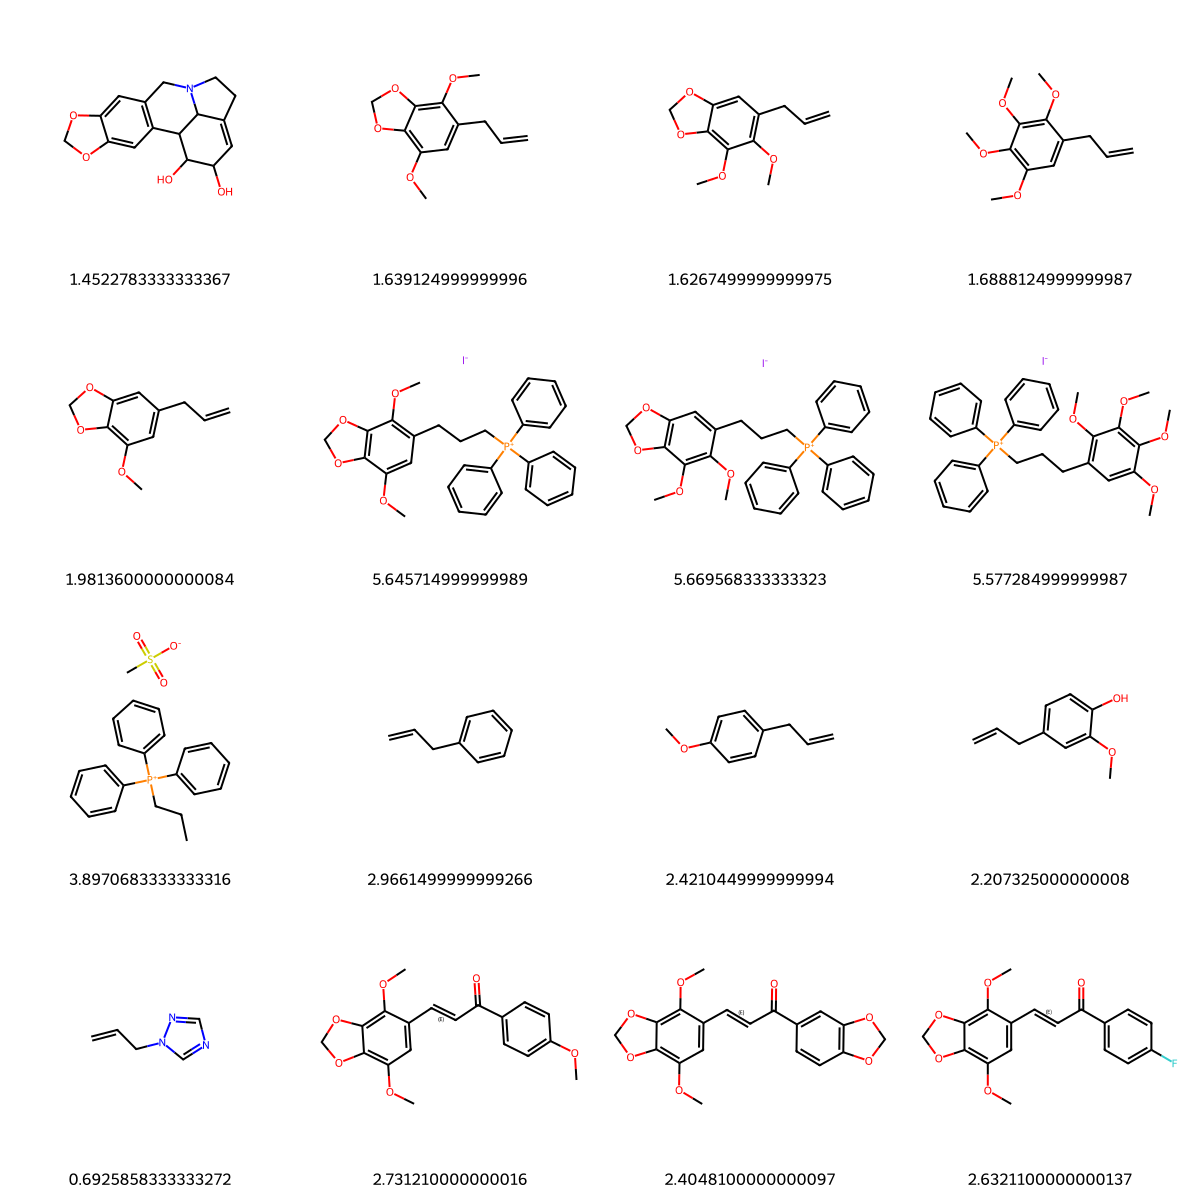

In [65]:
dm.to_image(mols=mols, legends=list(map(str, y_pred_paper)))